# Exploring results

> The idea behind performing the separable segmentation is that the output to the layer before the last one, could have some meaning that we could see. We're going to load the weights of an already trained model and see if this is true or not.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf


In [2]:
import os; os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
from pathlib import Path
from itertools import product
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
import cv2
import wandb
from wandb.keras import WandbCallback

## Data Loading

> We will be using CityScapes as a baseline.

The different training, validation and test subsets are divided in their correspondent folders:

In [4]:
path_root = Path("/media/disk/databases/dn_segmentation/cityscapes")
path_train = path_root / "train_data"
path_val = path_root / "validation_data"
path_test = path_root / "test_data"

We will now build a set of generators to load the data:

In [5]:
def get_label_path_from_img(path_img):
    path_label = str(path_img).split("_")
    path_label[-1] = "gtFine_color.png"
    path_label = "_".join(path_label)
    path_label = path_label.replace("images", "labels")
    path_label = Path(path_label)
    return path_label

In [6]:
def train_gen():
    for path_img in (path_train/"images").glob("*.png"):
        path_label = get_label_path_from_img(path_img)

        ## Load the images
        img = cv2.imread(str(path_img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dsize=(256,128))
        label = cv2.imread(str(path_label))
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
        label = cv2.resize(label, dsize=(256,128), interpolation=cv2.INTER_NEAREST)
        yield img, label

In [7]:
def val_gen():
    for path_img in (path_val/"images").glob("*.png"):
        path_label = get_label_path_from_img(path_img)

        ## Load the images
        img = cv2.imread(str(path_img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dsize=(256,128))
        label = cv2.imread(str(path_label))
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
        label = cv2.resize(label, dsize=(256,128), interpolation=cv2.INTER_NEAREST)
        yield img, label

In [8]:
a, b = next(train_gen())
a.shape, b.shape

((128, 256, 3), (128, 256, 3))

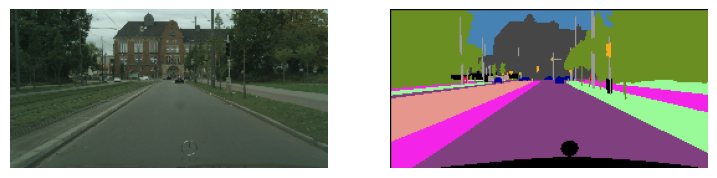

In [9]:
fig, axes = plt.subplots(1,2,figsize=(9,4))

axes[0].imshow(a)
axes[1].imshow(b)
for ax in axes: ax.axis("off")
plt.show()

### Turn the labels into a sparse representation

> The labels are loaded as colors, but now we need to turn them into sparse representations to be able to train our network.

First we will be obtaining the individual colors in the images:

In [10]:
colors = np.array([(0, 0, 0), (111, 74, 0), (81, 0, 81), (128, 64, 128), (244, 35, 232), (250, 170, 160), (230, 150, 140), (70, 70, 70), 
                   (102, 102, 156), (190, 153, 153), (180, 165, 180), (150, 100, 100), (150, 120, 90), (153, 153, 153), (250, 170, 30), (220, 220, 0), (107, 142, 35), 
                   (152, 251, 152), (70, 130, 180), (220, 20, 60), (255, 0, 0), ( 0, 0, 142), ( 0, 0, 70), (0, 60, 100), (0, 0, 90), (0, 0, 110), (0, 80, 100), (0, 0, 230), 
                   (119, 11, 32), (0, 0, 142)], dtype = np.int32)
colors = set([tuple(c) for c in colors])
len(colors)

29

Now we can build a dictionary mapping each color into one integer:

In [11]:
color2label = {color:i for i,color in enumerate(colors)}
label2color = {i:color for i,color in enumerate(colors)}
len(color2label)#, label2color

29

Finally, we can convert the label:

In [12]:
def prepare_label(label):
    new_label = np.empty(shape=label.shape[:-1])
    for i, j in product(range(label.shape[0]), range(label.shape[1])):
        color = label[i,j]
        new_label[i,j] = color2label[tuple(color)]
    return new_label

In [13]:
def prepare_label_one_hot(label):
    new_label = np.zeros(shape=(*label.shape[:-1], len(colors)))
    for i, j in product(range(label.shape[0]), range(label.shape[1])):
        color = label[i,j]
        idx = color2label[tuple(color)]
        new_label[i,j,idx] = 1
    return new_label

In [14]:
def one_hot_to_sparse(label):
    """Turns a one-hot encoded label into a sparse one."""
    return np.argmax(label, axis=-1)

## Building the `Dataset`

In [15]:
def train_gen():
    for path_img in (path_train/"images").glob("*.png"):
        path_label = get_label_path_from_img(path_img)

        ## Load the images
        img = cv2.imread(str(path_img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dsize=(256,128))
        label = cv2.imread(str(path_label))
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
        label = cv2.resize(label, dsize=(256,128), interpolation=cv2.INTER_NEAREST)

        ## Prepare the labels
        # label = prepare_label(label)
        label = prepare_label_one_hot(label)
        # label = tf.expand_dims(label, -1)
        
        yield img/255.0, label

In [16]:
def val_gen():
    for path_img in (path_val/"images").glob("*.png"):
        path_label = get_label_path_from_img(path_img)

        ## Load the images
        img = cv2.imread(str(path_img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dsize=(256,128))
        label = cv2.imread(str(path_label))
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
        label = cv2.resize(label, dsize=(256,128), interpolation=cv2.INTER_NEAREST)

        ## Prepare the labels
        # label = prepare_label(label)
        label = prepare_label_one_hot(label)
        # label = tf.expand_dims(label, -1)
        
        yield img/255.0, label

In [17]:
a, b = next(train_gen())
a.shape, b.shape

((128, 256, 3), (128, 256, 29))

In [18]:
dst_train = tf.data.Dataset.from_generator(
                            train_gen,
                            output_signature=(
                                tf.TensorSpec(a.shape, tf.float32),
                                tf.TensorSpec(b.shape, tf.int32),
                            ))

2022-11-25 12:07:43.528471: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5435 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:83:00.0, compute capability: 3.5


In [19]:
dst_val = tf.data.Dataset.from_generator(
                            val_gen,
                            output_signature=(
                                tf.TensorSpec(a.shape, tf.float32),
                                tf.TensorSpec(b.shape, tf.int32),
                            ))

## Defining the model

> The important part is going to be at the last part of the model.

In [20]:
# inputs = tf.keras.Input(shape=(1024,2048,3))
inputs = tf.keras.Input(shape=(128, 256,3))
# resize = layers.Resizing(128, 256)
conv1_e = layers.Conv2D(32, kernel_size=5, strides=1, padding="same", activation="relu")
conv2_e = layers.Conv2D(64, kernel_size=5, strides=1, padding="same", activation="relu")
conv3_e = layers.Conv2D(128, kernel_size=5, strides=1, padding="same", activation="relu")
pooling = layers.MaxPooling2D(2)
upsampling = layers.UpSampling2D(2)
conv2_d = layers.Conv2D(32, kernel_size=5, strides=1, padding="same", activation="relu")
conv1_d = layers.Conv2D(len(color2label)*3, kernel_size=5, strides=1, padding="same", activation="relu")
classifier = layers.Conv2D(len(color2label), kernel_size=1, groups=len(color2label), strides=1, padding="same", activation="softmax")

## Encoder
# inputs_resized = resize(inputs)
# output_1e = conv1_e(inputs_resized)
output_1e = conv1_e(inputs)
output_2e = conv2_e(pooling(output_1e))
output_3e = conv3_e(pooling(output_2e))

## Decoder

upsampled_3 = upsampling(output_3e)
output_2d = conv2_d(tf.concat([output_2e, upsampled_3], axis=-1))
upsampled_2 = upsampling(output_2d)
output_1d = conv1_d(tf.concat([output_1e, upsampled_2], axis=-1))

## Separable classifier
output_final = classifier(output_1d)

## Model
model = tf.keras.Model(inputs, output_final)
model.compile(optimizer="adam",
              loss=tf.losses.CategoricalCrossentropy(from_logits=False),
              # loss="mae",
              metrics=["accuracy",
                    #    tf.keras.metrics.IoU(num_classes=len(colors),
                    #                         target_class_ids=list(range(len(colors)))),
                       ])

## Loading the pre-trained weights

In [21]:
model.load_weights("trained_models/00_separable_segmentation.h5")

## Get a fixed batch

In [22]:
X_train, Y_train = dst_train.batch(8).take(1).get_single_element()
X_val, Y_val = dst_val.batch(8).take(1).get_single_element()

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

2022-11-25 12:08:41.197641: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(TensorShape([8, 128, 256, 3]),
 TensorShape([8, 128, 256, 29]),
 TensorShape([8, 128, 256, 3]),
 TensorShape([8, 128, 256, 29]))

## Explore the outputs

We don't actually want the output of the model, but the output of the layer before the last one:

In [26]:
model_ = tf.keras.Model(model.input, model.layers[-2].output)

In [27]:
pred_train = model_.predict(X_train)
pred_val = model_.predict(X_val)

pred_train.shape, pred_val.shape

2022-11-25 12:10:34.666960: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2022-11-25 12:10:35.143663: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


((8, 128, 256, 87), (8, 128, 256, 87))

Now we want to analyze the output channels in groups of 3 (resembling RGB or something like that):

In [41]:
a = one_hot_to_sparse(Y_train[0])
a.shape

(128, 256)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


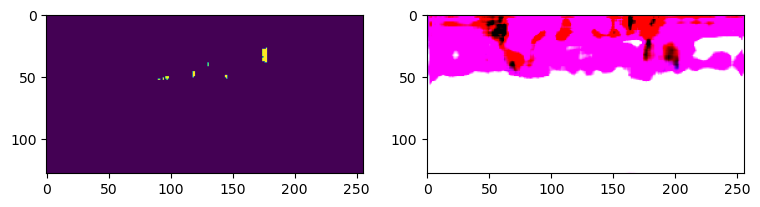

In [48]:
ch=15
fig, axes = plt.subplots(1,2,figsize=(9,4))
axes[0].imshow(one_hot_to_sparse(Y_train[0])==ch)
axes[1].imshow(pred_train[0,:,:,ch*3:ch*3+3])
plt.show()